## Cell type deconvolution using MacSGP

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import os

import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import sys
sys.path.append(r'/import/home2/share/yqzeng/MacSGP/codes')
import MacSGP

In [2]:
RAW_PATH = "/home/yzengbj/data/colorectal_cancer" # Raw data
DATA_PATH = "/import/home2/share/yqzeng/MacSGP/data/CRC" # Raw data
os.makedirs(os.path.join(DATA_PATH), exist_ok = True)

In [3]:
adata_ref = sc.read_10x_h5(os.path.join(RAW_PATH, 'sc', "HumanColonCancer_Flex_Multiplex_count_filtered_feature_bc_matrix.h5"))
meta = pd.read_csv(os.path.join(RAW_PATH, "HumanColonCancer_VisiumHD/MetaData/SingleCell_MetaData.csv"), index_col=0)
adata_ref.obs = meta.loc[adata_ref.obs.index]

adata_ref = adata_ref[adata_ref.obs["QCFilter"] == 'Keep', :]

In [9]:
adata_st = sc.read_h5ad(os.path.join(DATA_PATH, "xenium_p2_crc.h5ad"))
adata_st.obsm['spatial'] = np.array([adata_st.obs['x'], adata_st.obs['y']]).T

In [10]:
MacSGP.utils.Cal_Spatial_Net(adata_st, mode='KNN', k_cutoff=6)

Calculating spatial neighbor graph ...
The graph contains 2214760 edges, 326460 spots.
6.784169576670955 neighbors per spot on average.


In [12]:
adata_st, adata_basis = MacSGP.utils.preprocess(adata_st,adata_ref,
                                                celltype_ref_col = "Level2",
                                                n_hvg_group = 150)

Finding highly variable genes...
407 highly variable genes selected.
Calculate basis for deconvolution...
Preprocess ST data...


In [13]:
model = MacSGP.model.Model_deconv(adata_st, adata_basis, n_layers =4, training_steps=10000)
model.train(step_interval=1000, use_amp=False)
adata_st = model.eval()

  0%|          | 1/10000 [00:00<1:43:38,  1.61it/s]

Step: 0, Loss: 216.8512, d_loss: 213.2997, f_loss: 35.5146


 10%|█         | 1001/10000 [06:51<1:01:44,  2.43it/s]

Step: 1000, Loss: 64.5341, d_loss: 62.1040, f_loss: 24.3014


 20%|██        | 2001/10000 [13:42<54:50,  2.43it/s]  

Step: 2000, Loss: 59.8627, d_loss: 57.4985, f_loss: 23.6416


 30%|███       | 3001/10000 [20:33<48:02,  2.43it/s]

Step: 3000, Loss: 58.4121, d_loss: 56.0898, f_loss: 23.2228


 40%|████      | 4001/10000 [27:24<41:09,  2.43it/s]

Step: 4000, Loss: 57.7609, d_loss: 55.4757, f_loss: 22.8520


 50%|█████     | 5001/10000 [34:15<34:18,  2.43it/s]

Step: 5000, Loss: 57.4019, d_loss: 55.1460, f_loss: 22.5588


 60%|██████    | 6001/10000 [41:06<27:26,  2.43it/s]

Step: 6000, Loss: 57.2084, d_loss: 54.9799, f_loss: 22.2857


 70%|███████   | 7001/10000 [47:57<20:36,  2.43it/s]

Step: 7000, Loss: 57.0164, d_loss: 54.8167, f_loss: 21.9972


 80%|████████  | 8001/10000 [54:48<13:42,  2.43it/s]

Step: 8000, Loss: 56.9264, d_loss: 54.7555, f_loss: 21.7086


 90%|█████████ | 9001/10000 [1:01:39<06:51,  2.43it/s]

Step: 9000, Loss: 56.7884, d_loss: 54.6482, f_loss: 21.4019


100%|██████████| 10000/10000 [1:08:30<00:00,  2.43it/s]


In [15]:
adata_st.write_h5ad(os.path.join(DATA_PATH, "xenium.h5ad"))
adata_basis.write_h5ad(os.path.join(DATA_PATH, "xenium_basis.h5ad"))

Dropping cell types: ['Epithelial', 'Memory B', 'NK', 'SM Stress Response', 'Tumor I']


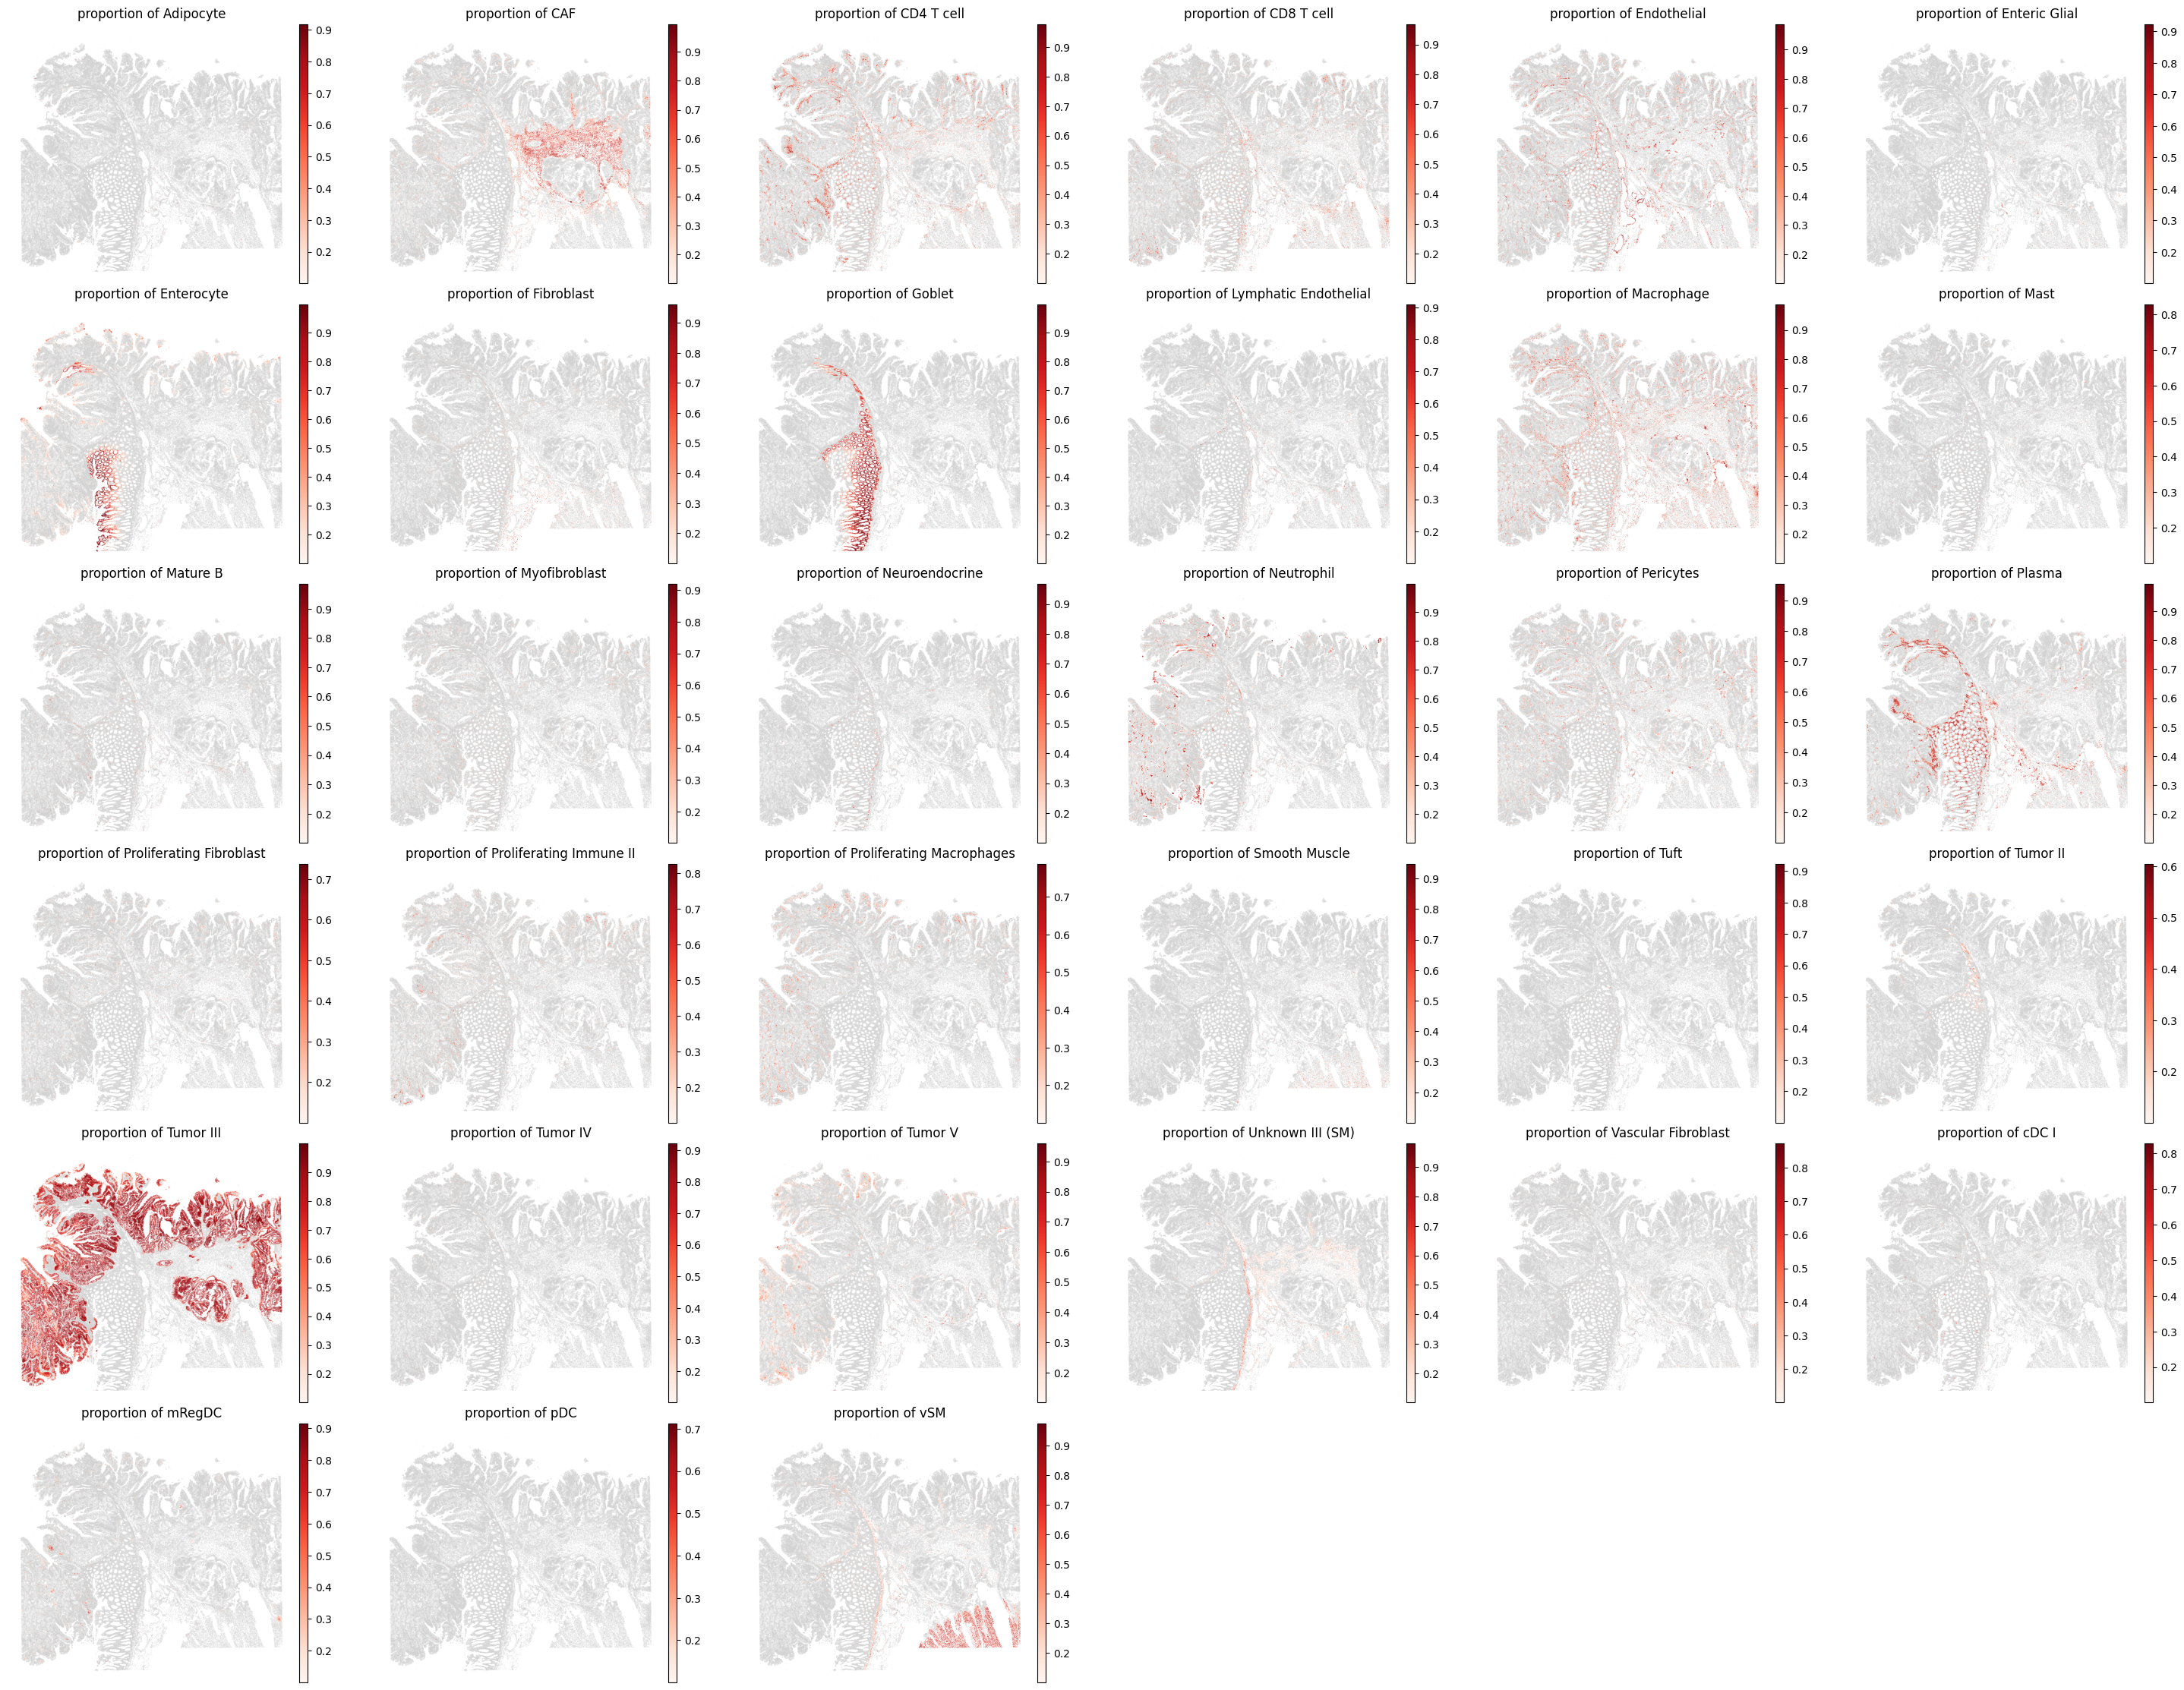

In [18]:
from MacSGP.vis import plot_spatial_ct

plot_spatial_ct(adata_st, index='proportion',
                proportion_threshold=0.1, num_threshold=100, 
                cmap='Reds', 
                spot_size=10, 
                ncols=6)